In [1]:
from gensim.models import KeyedVectors

input_file = './util/glove.6B.100d.txt'
model_glove = KeyedVectors.load_word2vec_format(input_file,
                                                binary=False,
                                                no_header=True)

In [2]:
from gensim.models import KeyedVectors

# Load the model
filename = './util/GoogleNews-vectors-negative300.bin'
model_wv = KeyedVectors.load_word2vec_format(filename, binary=True)

In [3]:
import fasttext
model_ft = fasttext.load_model('./util/cc.en.300.bin')

In [4]:
all_models = [model_glove, model_ft, model_wv]
model_names = ['glove', 'fasttext', 'word2vec']

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

In [7]:
import util.normalization as norm
import util.model as models
import util.utility as util

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
df = pd.read_csv("./sample-phone.csv")
df = df[['title', 'body']].reset_index(names='id')
df['review'] = df['title'] + ". " + df['body']
df = df.drop(['title', 'body'], axis=1)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      100 non-null    int64 
 1   review  100 non-null    object
dtypes: int64(1), object(1)
memory usage: 1.7+ KB
None


,id,review
0,0,Best phone money can buy. So far this phone is...
1,1,Pixel 3 has frequent display defects. I like t...
2,2,the lower left corner of the phone doesnt work...
3,3,"Great phone, be careful with the sellers. The ..."
4,4,U had no issue with the seller they were great...


# Normalization

In [9]:
# Tokenization into sentence

df_st = df[['id', 'review']].copy()

# Sentence Tokenization
df_st['token_sentence'] = df_st['review'].apply(norm.sentence_tokenize)
df_st = df_st.explode('token_sentence')
df_st['token_sentence'] = df_st['token_sentence'].str.strip()

# Remove non-ASCII
df_st['token_sentence'] = df_st['token_sentence'].apply(norm.remove_non_ascii)

# Expand contractions
df_st['token_sentence'] = df_st['token_sentence'].apply(norm.expand_contractions)

# Remove characters
df_st['token_sentence'] = df_st['token_sentence'].apply(norm.remove_characters, args=(True,))

# Remove enter tab
df_st['token_clean'] = df_st['token_sentence'].apply(norm.remove_enter_tab)

# Lemmatization
df_st['token_clean'] = df_st['token_clean'].apply(norm.lemmatize_text)

# Get Aspect

In [10]:
# Get aspect from rules
tqdm.pandas()
df_st['sub_aspect'] = df_st['token_clean']\
                        .progress_apply(util.get_aspect_rules)

100%|████████████████████████████████████████████████████████████████████████████████| 972/972 [01:43<00:00,  9.43it/s]


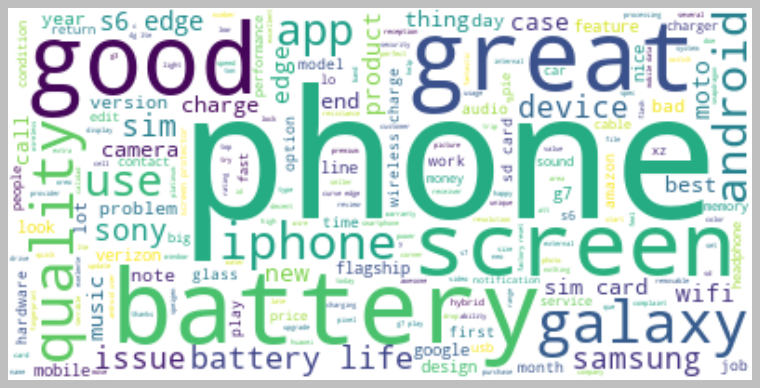

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ""
sub_aspect = df_st['sub_aspect'].values
for i in range(df_st.shape[0]):
    text = text + " " + " ".join(list(sub_aspect[i]))
    

text = text.strip()

wordcloud = WordCloud(background_color='white').generate(text)
plt.style.use('classic')
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [12]:
aspects = ['battery', 'screen', 'case']

def fun1(x, model):
    temp = set()
    for e in x:
        aspect = util.get_nearest_word(e, aspects, model)
        if aspect:
            temp.add(aspect)
    temp = list(temp)
    return temp

for model, name in zip(all_models, model_names):
    tqdm.pandas()
    df_st[f'aspect_{name}'] = df_st['sub_aspect'].progress_apply(fun1, args=(model,))
df_st

100%|███████████████████████████████████████████████████████████████████████████████| 972/972 [00:01<00:00, 758.01it/s]


,id,review,token_sentence,token_clean,sub_aspect,aspect_glove,aspect_fasttext,aspect_word2vec
0,0,Best phone money can buy. So far this phone is...,Best phone money can buy.,best phone money can buy .,"{phone money, best phone, money best}","[screen, case]","[case, battery]","[case, battery]"
0,0,Best phone money can buy. So far this phone is...,So far this phone is the bees knees.,so far this phone be the bee knee .,"{phone, bee knee}","[screen, case]",[battery],[battery]
1,1,Pixel 3 has frequent display defects. I like t...,Pixel 3 has frequent display defects.,pixel 3 have frequent display defect .,"{pixel, display defect, frequent display}",[screen],[screen],"[screen, battery]"
1,1,Pixel 3 has frequent display defects. I like t...,I like this phone model.,i like this phone model .,{phone model},[screen],[battery],[battery]
1,1,Pixel 3 has frequent display defects. I like t...,I bought this phone as a gift to my wife.,i buy this phone as a gift to my wife .,{phone},[screen],[battery],[battery]
...,...,...,...,...,...,...,...,...
99,99,Superb Seller not great product. I had two iss...,2 Struggled to get cell signalATT.,2 struggle to get cell signalatt .,"{cell signalatt, struggle}","[case, battery]","[case, battery]","[case, battery]"
99,99,Superb Seller not great product. I had two iss...,Phone feels good I have the Qualcomm US versio...,phone feel good i have the qualcomm u version ...,"{phone, qualcomm}","[screen, battery]",[battery],"[screen, battery]"
99,99,Superb Seller not great product. I had two iss...,It might have been a bad unit or the Korean ch...,it might have be a bad unit or the korean chip...,"{bad unit, korean chip}","[screen, case]","[screen, battery]","[case, battery]"
99,99,Superb Seller not great product. I had two iss...,Seller is impressive,seller be impressive,{seller},[case],[case],[case]


In [13]:
df_st['aspect_glove'].value_counts()

[]                         313
[screen]                   245
[case]                     161
[screen, case]             128
[battery]                   39
[case, battery]             31
[screen, battery]           30
[screen, case, battery]     25
Name: aspect_glove, dtype: int64

# Sentiment Analysis

In [14]:
tqdm.pandas()
df_st['pattern_prediction'] = df_st['token_clean']\
                    .progress_apply(models.pattern_lexicon_model)

100%|██████████████████████████████████████████████████████████████████████████████| 972/972 [00:00<00:00, 1989.14it/s]


In [15]:
tqdm.pandas()
df_st['roberta_prediction'] = df_st['token_sentence']\
                        .progress_apply(models.roberta_model)

100%|████████████████████████████████████████████████████████████████████████████████| 972/972 [23:08<00:00,  1.43s/it]


# Get Result

In [16]:
def get_result(aspect, model, emb_name):
    
    # Initialization
    get_aspects = df_st[f'aspect_{emb_name}'].values
    get_predictions = df_st[model].values
    
    temp = []

    for i in range(len(get_aspects)):
        if (not get_aspects[i]) or (aspect not in get_aspects[i]):
            temp.append(0)
        else:
            if get_predictions[i] == 'negative':
                temp.append(-99)
            else:
                temp.append(1)
    return np.array(temp)

In [17]:

get_pattern = df_st['pattern_prediction'].values
get_roberta = df_st['roberta_prediction'].values

new_fields = set()
for name in model_names:
    for aspect in aspects:

        df_st[aspect + f"_pattern_{name}"] = get_result(aspect, 'pattern_prediction', name)
        df_st[aspect + f"_roberta_{name}"] = get_result(aspect, 'roberta_prediction', name)
        new_fields.add(aspect + f"_pattern_{name}")
        new_fields.add(aspect + f"_roberta_{name}")

new_fields = list(new_fields)
print(df_st.info())
df_st

<class 'pandas.core.frame.DataFrame'>
Int64Index: 972 entries, 0 to 99
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        972 non-null    int64 
 1   review                    972 non-null    object
 2   token_sentence            972 non-null    object
 3   token_clean               972 non-null    object
 4   sub_aspect                972 non-null    object
 5   aspect_glove              972 non-null    object
 6   aspect_fasttext           972 non-null    object
 7   aspect_word2vec           972 non-null    object
 8   pattern_prediction        972 non-null    object
 9   roberta_prediction        972 non-null    object
 10  battery_pattern_glove     972 non-null    int32 
 11  battery_roberta_glove     972 non-null    int32 
 12  screen_pattern_glove      972 non-null    int32 
 13  screen_roberta_glove      972 non-null    int32 
 14  case_pattern_glove        9

,id,review,token_sentence,token_clean,sub_aspect,aspect_glove,aspect_fasttext,aspect_word2vec,pattern_prediction,roberta_prediction,...,screen_pattern_fasttext,screen_roberta_fasttext,case_pattern_fasttext,case_roberta_fasttext,battery_pattern_word2vec,battery_roberta_word2vec,screen_pattern_word2vec,screen_roberta_word2vec,case_pattern_word2vec,case_roberta_word2vec
0,0,Best phone money can buy. So far this phone is...,Best phone money can buy.,best phone money can buy .,"{phone money, best phone, money best}","[screen, case]","[case, battery]","[case, battery]",positive,positive,...,0,0,1,1,1,1,0,0,1,1
0,0,Best phone money can buy. So far this phone is...,So far this phone is the bees knees.,so far this phone be the bee knee .,"{phone, bee knee}","[screen, case]",[battery],[battery],positive,positive,...,0,0,0,0,1,1,0,0,0,0
1,1,Pixel 3 has frequent display defects. I like t...,Pixel 3 has frequent display defects.,pixel 3 have frequent display defect .,"{pixel, display defect, frequent display}",[screen],[screen],"[screen, battery]",positive,negative,...,1,-99,0,0,1,-99,1,-99,0,0
1,1,Pixel 3 has frequent display defects. I like t...,I like this phone model.,i like this phone model .,{phone model},[screen],[battery],[battery],negative,positive,...,0,0,0,0,-99,1,0,0,0,0
1,1,Pixel 3 has frequent display defects. I like t...,I bought this phone as a gift to my wife.,i buy this phone as a gift to my wife .,{phone},[screen],[battery],[battery],negative,positive,...,0,0,0,0,-99,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,99,Superb Seller not great product. I had two iss...,2 Struggled to get cell signalATT.,2 struggle to get cell signalatt .,"{cell signalatt, struggle}","[case, battery]","[case, battery]","[case, battery]",negative,negative,...,0,0,-99,-99,-99,-99,0,0,-99,-99
99,99,Superb Seller not great product. I had two iss...,Phone feels good I have the Qualcomm US versio...,phone feel good i have the qualcomm u version ...,"{phone, qualcomm}","[screen, battery]",[battery],"[screen, battery]",positive,positive,...,0,0,0,0,1,1,1,1,0,0
99,99,Superb Seller not great product. I had two iss...,It might have been a bad unit or the Korean ch...,it might have be a bad unit or the korean chip...,"{bad unit, korean chip}","[screen, case]","[screen, battery]","[case, battery]",negative,negative,...,-99,-99,0,0,-99,-99,0,0,-99,-99
99,99,Superb Seller not great product. I had two iss...,Seller is impressive,seller be impressive,{seller},[case],[case],[case],positive,positive,...,0,0,1,1,0,0,0,0,1,1


In [18]:
grouped_df = df_st[ ['id'] + new_fields ].groupby('id').sum()

grouped_df = grouped_df.applymap(lambda x: 0 if x < 0 else 1).reset_index()

grouped_df

,id,screen_pattern_fasttext,battery_pattern_word2vec,battery_pattern_fasttext,case_pattern_word2vec,battery_roberta_fasttext,battery_roberta_word2vec,screen_roberta_word2vec,case_pattern_fasttext,screen_pattern_glove,case_roberta_glove,screen_roberta_fasttext,case_pattern_glove,case_roberta_fasttext,screen_pattern_word2vec,case_roberta_word2vec,screen_roberta_glove,battery_pattern_glove,battery_roberta_glove
0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,1
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0,0,0,0,1,1,1,1,0,1,1,0,1,0,1,1,0,1
96,96,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1,1,1,1
97,97,0,0,0,1,1,1,0,1,0,0,0,1,0,0,0,0,1,1
98,98,0,0,0,0,1,1,1,0,0,1,1,0,1,0,1,1,0,1


In [19]:
result = df.merge(grouped_df, on='id', how='left')

print(result.info())
result.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        100 non-null    int64 
 1   review                    100 non-null    object
 2   screen_pattern_fasttext   100 non-null    int64 
 3   battery_pattern_word2vec  100 non-null    int64 
 4   battery_pattern_fasttext  100 non-null    int64 
 5   case_pattern_word2vec     100 non-null    int64 
 6   battery_roberta_fasttext  100 non-null    int64 
 7   battery_roberta_word2vec  100 non-null    int64 
 8   screen_roberta_word2vec   100 non-null    int64 
 9   case_pattern_fasttext     100 non-null    int64 
 10  screen_pattern_glove      100 non-null    int64 
 11  case_roberta_glove        100 non-null    int64 
 12  screen_roberta_fasttext   100 non-null    int64 
 13  case_pattern_glove        100 non-null    int64 
 14  case_roberta_fasttext     1

,id,review,screen_pattern_fasttext,battery_pattern_word2vec,battery_pattern_fasttext,case_pattern_word2vec,battery_roberta_fasttext,battery_roberta_word2vec,screen_roberta_word2vec,case_pattern_fasttext,screen_pattern_glove,case_roberta_glove,screen_roberta_fasttext,case_pattern_glove,case_roberta_fasttext,screen_pattern_word2vec,case_roberta_word2vec,screen_roberta_glove,battery_pattern_glove,battery_roberta_glove
0,0,Best phone money can buy. So far this phone is...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,Pixel 3 has frequent display defects. I like t...,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,1
2,2,the lower left corner of the phone doesnt work...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,3,"Great phone, be careful with the sellers. The ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,4,U had no issue with the seller they were great...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1


# Evaluation

In [20]:
df_val = pd.read_csv('validation-phone.csv')

print(df_val.info())
df_val.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   asin          100 non-null    object
 1   name          100 non-null    object
 2   rating        100 non-null    int64 
 3   date          100 non-null    object
 4   verified      100 non-null    bool  
 5   title         100 non-null    object
 6   body          100 non-null    object
 7   helpfulVotes  100 non-null    int64 
 8   phone         100 non-null    object
 9   battery       100 non-null    object
 10  screen        100 non-null    object
 11  issue         100 non-null    object
 12  case          100 non-null    object
 13  sim           100 non-null    object
 14  seller        100 non-null    object
 15  service       100 non-null    object
dtypes: bool(1), int64(2), object(13)
memory usage: 11.9+ KB
None


,asin,name,rating,date,verified,title,body,helpfulVotes,phone,battery,screen,issue,case,sim,seller,service
0,B07K76LBLZ,PlaYboY BuNnY,5,"February 14, 2019",True,Best phone money can buy,So far this phone is the bees knees.,3,Positive,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral
1,B07P8MQHSH,Gemini_13,3,"August 2, 2019",True,Pixel 3 has frequent display defects,I like this phone model. I bought this phone a...,20,Negative,Neutral,Negative,Negative,Neutral,Neutral,Negative,Negative
2,B01NC2MEJP,Kashm30uttz,2,"April 30, 2018",True,the lower left corner of the phone doesnt work...,the lower left corner of the phone doesnt work...,1,Negative,Neutral,Negative,Negative,Neutral,Neutral,Negative,Negative
3,B018OMP8ES,Techie241,3,"January 16, 2017",True,"Great phone, be careful with the sellers","The phone is wonderful, if you're considering ...",10,Positive,Neutral,Neutral,Negative,Neutral,Neutral,Negative,Neutral
4,B07QC4R451,Michelle Wildhagen,1,"June 22, 2019",True,U had no issue with the seller they were great...,I was very disappointed in the way this phone ...,3,Negative,Neutral,Neutral,Negative,Neutral,Neutral,Neutral,Negative


In [21]:
def mapping_sentiment(x):
    if x == 'Negative':
        return 0
    else:
        return 1    

    
for aspect in aspects:
    df_val[aspect] = df_val[aspect].apply(mapping_sentiment)

print(df_val.info())
df_val.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   asin          100 non-null    object
 1   name          100 non-null    object
 2   rating        100 non-null    int64 
 3   date          100 non-null    object
 4   verified      100 non-null    bool  
 5   title         100 non-null    object
 6   body          100 non-null    object
 7   helpfulVotes  100 non-null    int64 
 8   phone         100 non-null    object
 9   battery       100 non-null    int64 
 10  screen        100 non-null    int64 
 11  issue         100 non-null    object
 12  case          100 non-null    int64 
 13  sim           100 non-null    object
 14  seller        100 non-null    object
 15  service       100 non-null    object
dtypes: bool(1), int64(5), object(10)
memory usage: 11.9+ KB
None


,asin,name,rating,date,verified,title,body,helpfulVotes,phone,battery,screen,issue,case,sim,seller,service
0,B07K76LBLZ,PlaYboY BuNnY,5,"February 14, 2019",True,Best phone money can buy,So far this phone is the bees knees.,3,Positive,1,1,Neutral,1,Neutral,Neutral,Neutral
1,B07P8MQHSH,Gemini_13,3,"August 2, 2019",True,Pixel 3 has frequent display defects,I like this phone model. I bought this phone a...,20,Negative,1,0,Negative,1,Neutral,Negative,Negative
2,B01NC2MEJP,Kashm30uttz,2,"April 30, 2018",True,the lower left corner of the phone doesnt work...,the lower left corner of the phone doesnt work...,1,Negative,1,0,Negative,1,Neutral,Negative,Negative
3,B018OMP8ES,Techie241,3,"January 16, 2017",True,"Great phone, be careful with the sellers","The phone is wonderful, if you're considering ...",10,Positive,1,1,Negative,1,Neutral,Negative,Neutral
4,B07QC4R451,Michelle Wildhagen,1,"June 22, 2019",True,U had no issue with the seller they were great...,I was very disappointed in the way this phone ...,3,Negative,1,1,Negative,1,Neutral,Neutral,Negative


In [22]:
from sklearn.metrics import classification_report, roc_auc_score

for name in model_names:
    print(f"Prediction pattern {name}")
    print("==============================================================")
    for aspect in aspects:
        try:
            actual = df_val[aspect]
            pred = result[aspect + f"_pattern_{name}"]
            print(f"ROC AUC Score: ", roc_auc_score(actual, pred))
            print(f"Result {aspect}")
            print(classification_report(actual, pred))
        except:
            continue

Prediction pattern glove
ROC AUC Score:  0.6268939393939393
Result battery
              precision    recall  f1-score   support

           0       0.19      0.58      0.29        12
           1       0.92      0.67      0.78        88

    accuracy                           0.66       100
   macro avg       0.56      0.63      0.53       100
weighted avg       0.83      0.66      0.72       100

ROC AUC Score:  0.6868131868131868
Result screen
              precision    recall  f1-score   support

           0       0.14      1.00      0.24         9
           1       1.00      0.37      0.54        91

    accuracy                           0.43       100
   macro avg       0.57      0.69      0.39       100
weighted avg       0.92      0.43      0.52       100

ROC AUC Score:  0.43877551020408156
Result case
              precision    recall  f1-score   support

           0       0.02      0.50      0.03         2
           1       0.97      0.38      0.54        98

    accura

In [23]:
for name in model_names:
    print(f"Prediction roberta {name}")
    print("==============================================================")
    for aspect in aspects:
        try:
            actual = df_val[aspect]
            pred = result[aspect + f"_roberta_{name}"]
            print(f"ROC AUC Score: ", roc_auc_score(actual, pred))
            print(f"Result {aspect}")
            print(classification_report(actual, pred))
        except:
            continue

Prediction roberta glove
ROC AUC Score:  0.6628787878787878
Result battery
              precision    recall  f1-score   support

           0       0.38      0.42      0.40        12
           1       0.92      0.91      0.91        88

    accuracy                           0.85       100
   macro avg       0.65      0.66      0.66       100
weighted avg       0.86      0.85      0.85       100

ROC AUC Score:  0.7747252747252747
Result screen
              precision    recall  f1-score   support

           0       0.18      1.00      0.31         9
           1       1.00      0.55      0.71        91

    accuracy                           0.59       100
   macro avg       0.59      0.77      0.51       100
weighted avg       0.93      0.59      0.67       100

ROC AUC Score:  0.7602040816326531
Result case
              precision    recall  f1-score   support

           0       0.04      1.00      0.08         2
           1       1.00      0.52      0.68        98

    accurac